本项目是为完成kaggle竞赛题(Dogs vs. Cats Redux: Kernels Edition)而作，地址：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import os
from PIL import Image,ImageOps
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import torch
import torch.nn as nn
from torchvision import transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

一、数据预处理  

1、读取/train下的文件名，并根据文件名判断标签。

In [2]:
data_dir='./dataset/' #数据目录
train_dir=os.path.join(data_dir,'train') #训练集原始文件夹
image_names=os.listdir(train_dir) #原始文件名
image_paths=[os.path.join(train_dir,fn) for fn in image_names] #原始文件路径
train_sets_dir=os.path.join(data_dir,'train_sets') #准备放训练集的新文件夹

In [5]:

#创建新的文件夹train_sets，注意此处会删除旧的train_sets文件夹。
import shutil
if os.path.exists(train_sets_dir):
    shutil.rmtree(train_sets_dir)
os.mkdir(train_sets_dir)


In [6]:

#图片过滤器。功能：去除图片的白色边缘。
def image_filter(path):
    image=cv2.imread(path)[2:-2,2:-2]
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask=cv2.inRange(image,np.array([215,215,215]),np.array([255,255,255]))
    pil_mask=Image.fromarray(mask)
    bbox=ImageOps.invert(pil_mask).getbbox()
    return Image.fromarray(image).crop([*bbox])

#第一次清洗数据，并将图片保存至'./dataset/train_sets/'  
for path in image_paths:
    cropped_image=image_filter(path)
    #过滤掉像素小于3600的图片
    if cropped_image.size[0]*cropped_image.size[1]>3600:
        cropped_image.save(os.path.join(train_sets_dir,os.path.basename(path)))


In [3]:

image_names=os.listdir(train_sets_dir)
data_size=len(image_names)
print('%d images remaining.'%data_size)


24973 images remaining.


2、分割训练集和验证集。为保证模型均衡学习猫狗特征，取数量相等的猫和狗作为训练集。

In [4]:
#把dog和cat分装到两个列表dogs和cats，并附加标签
dogs,cats=[],[]
for fn in image_names:
    dogs.append((os.path.join(train_sets_dir,fn),1)) if 'dog' in fn else cats.append((os.path.join(train_sets_dir,fn),0))
    
#取80%的样本作为训练集
sample_size=int(data_size*0.8*0.5)    
#分割训练集和验证集
train_dogs,valid_dogs=train_test_split(dogs,train_size=sample_size,random_state=42,shuffle=True)
train_cats,valid_cats=train_test_split(cats,train_size=sample_size,random_state=42,shuffle=True)
train_sets=train_dogs+train_cats
valid_sets=valid_dogs+valid_cats
train_size=len(train_sets)
valid_size=len(valid_sets)

print('train_sets: %d, including:%d dogs and %d cats.\nvalid_sets: %d, including:%d dogs and %d cats.'
      %(train_size,len(train_dogs),len(train_cats),valid_size,len(valid_dogs),len(valid_cats)))

train_sets: 19978, including:9989 dogs and 9989 cats.
valid_sets: 4995, including:2492 dogs and 2503 cats.


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


3、创建transform，用于图片转换。为了确保两个模型输入的是相同的图片，我们未使用任何随机裁剪、翻转。

In [5]:
transform={
#transforms for ResNet50
'resnet':transforms.Compose([transforms.Resize(250),
                             transforms.RandomCrop(224),
                             transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
    
#transforms for Inception v3
'inception':transforms.Compose([transforms.Resize(299),
                                transforms.RandomCrop(299),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])}

4、定义batch变换函数batch_transform。从文件路径读取，到变换成适合模型维度的Tensor

In [6]:
#read the image, return the input of model
def batch_transform(paths,transform):
    return torch.cat(tuple(transform(Image.open(path)).unsqueeze(0) for path in paths))

5、给训练集和验证集分别创建DataLoader

In [7]:
train_batch=32 #训练集batch size
valid_batch=32 #验证集集batch size

#创建DataLoader
train_loader=torch.utils.data.DataLoader(train_sets,batch_size=train_batch,shuffle=True,num_workers=4,drop_last=True)
valid_loader=torch.utils.data.DataLoader(valid_sets,batch_size=valid_batch,shuffle=True,num_workers=4,drop_last=True)

6、展示转换后的图像。

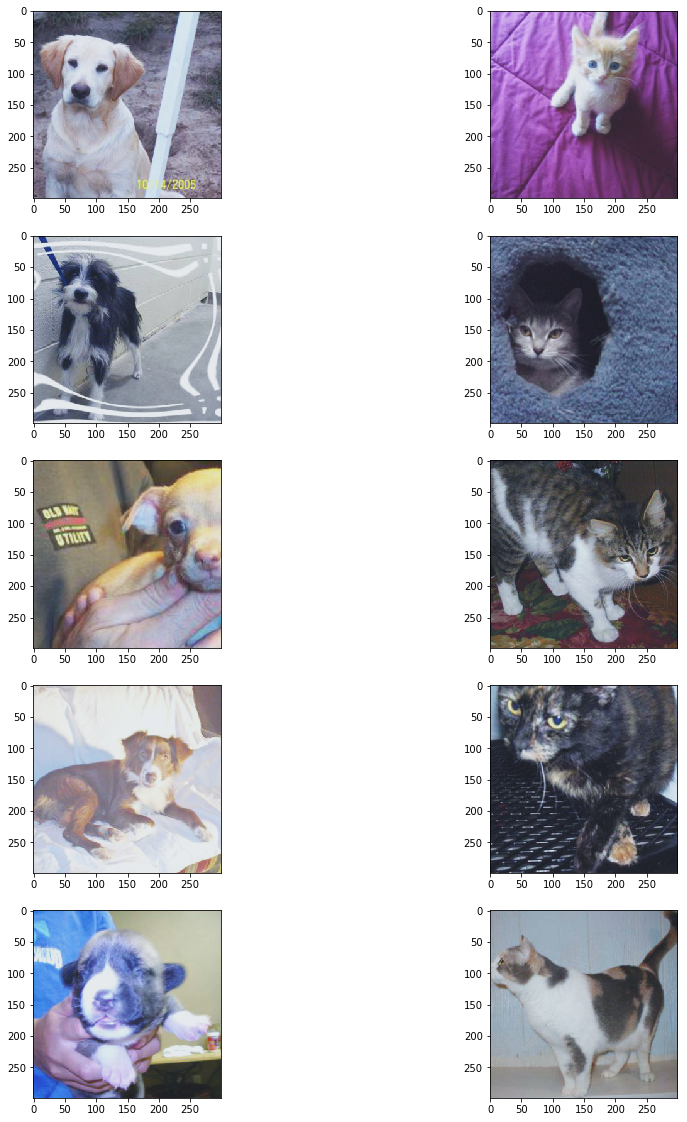

In [8]:
#定义展示转换图像的函数
def trans_images_show(datasets,transform):
    trans4plot=[torch.sigmoid(transform(Image.open(path))).permute(1,2,0) for path,_ in datasets]
    size=len(trans4plot)
    fig,ax=plt.subplots(int(size/2),2,figsize=(15,size*2))
    for i in range(size):
        row,col=(i,0) if i<size/2 else (int(i-size/2),1)
        ax[row,col].imshow(trans4plot[i])
        
#展示转换后的图像
trans_images_show(train_dogs[:5]+train_cats[:5],transform['inception'])

二、搭建网络  

1、本项目使用迁移学习的方式实现分类器。定义混合模型类FusionNet，该类包含预训练的CNN模型：ResNet50和Inception_v3。  
(*这里有一个小trick，因为pytorch无法下载不带fc层的模型，我自定义了一个nn.Module的子类FC，用于替换ResNet50和Inception_v3的fc层。*)

In [6]:
'''
#计算模型参数的长度
def len_of(generator):
    return sum(1 for _ in generator.parameters())
'''

In [8]:
#用于替换ResNet50和Inception_v3的fc层
class FC(nn.Module):
    def __init__(self):
        super(FC,self).__init__()
        
    def forward(self,x):
        return x

#定义混合模型
class FusionNet(nn.Module):
    def __init__(self,require_grad=False):
        super(FusionNet,self).__init__()
        
        self.resnet=models.resnet50(pretrained=True)
        self.resnet.fc=FC()
        
        self.inception=models.inception_v3(pretrained=True)
        self.inception.aux_logits=False
        self.inception.fc=FC()
        
        if require_grad:
            for i,param in enumerate(self.resnet.parameters()):
                if i<129:
                    param.requires_grad=False
            for i,param in enumerate(self.inception.parameters()):
                if i<218:
                    param.requires_grad=False
        else:
            for param in self.resnet.parameters():
                param.requires_grad=False
            for param in self.inception.parameters():
                param.requires_grad=False
            
        self.classifier=nn.Sequential(nn.BatchNorm1d(4096),
                                      nn.Linear(4096,2048),
                                      nn.ReLU(),
                                      nn.Linear(2048,1024),
                                      nn.ReLU(),
                                      nn.Linear(1024,512),
                                      nn.ReLU(),
                                      nn.Linear(512,2))
        
    def forward(self,res_input,inc_input):
        res_output=self.resnet(res_input)
        inc_output=self.inception(inc_input)
        x=torch.cat((res_output,inc_output),dim=1)
        x=self.classifier(x)
        return x

In [10]:
#第一次训练不更新ResNet50、Inception_v3参数
model=FusionNet(require_grad=False)

#为在GPU上训练做准备
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 17514213.24it/s]
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:06<00:00, 16879044.66it/s]


2、定义损失函数

In [9]:
criterion=nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

3、定义优化器

In [12]:
#第一次训练不更新ResNet50、Inception_v3参数
optimizer=torch.optim.SGD(model.classifier.parameters(),lr=0.001,momentum=0.91)

三、训练网络  

1、准备训练参数

In [13]:
epochs=2
every=4
epoch_dict={'loss':{'train':[],'valid':[]},'acc':{'train':[],'valid':[]}}
running={'loss':{'train':[],'valid':[]},'acc':{'train':[],'valid':[]}}

2、第一次训练模型

In [14]:
for epoch in range(1,epochs+1):
    count=0
    running_loss=0
    running_acc=0
    valid_iter=iter(valid_loader)
    
    #train
    model.train()
    for paths,labels in train_loader:
        res_input=batch_transform(paths,transform['resnet'])
        inc_input=batch_transform(paths,transform['inception'])
        res_input=res_input.to(device)
        inc_input=inc_input.to(device)
        optimizer.zero_grad() #计算梯度前清空历史梯度
        output=model(res_input, inc_input)
        labels=labels.to(device)
        loss=criterion(output,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        train_acc=accuracy_score(torch.argmax(output,dim=1),labels)
        running_acc+=train_acc

        count+=1
        print('epoch:%d, training:%d/%d, loss:%.6f, accuracy:%.4f\r'%(epoch,train_batch*count,train_size,loss,train_acc),end='')
        if count%every==0:
            average_loss=running_loss/every #every个batch的平均loss
            average_acc=running_acc/every #every个batch的平均accuracy
            print('epoch:%d, training:%d/%d, average_loss:%.6f, accuracy:%.4f\r'
                  %(epoch,train_batch*count,train_size,average_loss,average_acc))
            running['loss']['train'].append(average_loss)
            running['acc']['train'].append(average_acc)
            running_loss=0
            running_acc=0
            
    e_count=int(count/every)
    e_train_loss=sum(running['loss']['train'][-e_count:])/e_count
    e_train_acc=sum(running['acc']['train'][-e_count:])/e_count
    print('\nepoch %d, average training loss:%.6f ; training accuracy:%.4f'%(epoch,e_train_loss,e_train_acc))
    epoch_dict['loss']['train'].append(e_train_loss)
    epoch_dict['acc']['train'].append(e_train_acc)
    torch.save(model.state_dict(),'./FusionNet-try-%s.pkl'%epoch)
    torch.save(running,'./running-try-%s.pkl'%epoch)
    torch.save(epoch_dict,'./epoch_dict-try-%s.pkl'%epoch)
    #scheduler.step()

epoch:1, training:128/19978, average_loss:0.659547, accuracy:0.6484
epoch:1, training:256/19978, average_loss:0.538229, accuracy:0.9062
epoch:1, training:384/19978, average_loss:0.416368, accuracy:0.9453
epoch:1, training:512/19978, average_loss:0.294617, accuracy:0.9453
epoch:1, training:640/19978, average_loss:0.249520, accuracy:0.9531
epoch:1, training:768/19978, average_loss:0.203983, accuracy:0.9453
epoch:1, training:896/19978, average_loss:0.170839, accuracy:0.9453
epoch:1, training:1024/19978, average_loss:0.174609, accuracy:0.9688
epoch:1, training:1152/19978, average_loss:0.163043, accuracy:0.9297
epoch:1, training:1280/19978, average_loss:0.084183, accuracy:1.0000
epoch:1, training:1408/19978, average_loss:0.072517, accuracy:0.9844
epoch:1, training:1536/19978, average_loss:0.131634, accuracy:0.9766
epoch:1, training:1664/19978, average_loss:0.086944, accuracy:0.9844
epoch:1, training:1792/19978, average_loss:0.087857, accuracy:0.9844
epoch:1, training:1920/19978, average_los

epoch:2, training:10240/19978, average_loss:0.060931, accuracy:0.9688
epoch:2, training:10368/19978, average_loss:0.080404, accuracy:0.9766
epoch:2, training:10496/19978, average_loss:0.043102, accuracy:0.9844
epoch:2, training:10624/19978, average_loss:0.032363, accuracy:0.9922
epoch:2, training:10752/19978, average_loss:0.065814, accuracy:0.9766
epoch:2, training:10880/19978, average_loss:0.106693, accuracy:0.9297
epoch:2, training:11008/19978, average_loss:0.030675, accuracy:0.9922
epoch:2, training:11136/19978, average_loss:0.078808, accuracy:0.9766
epoch:2, training:11264/19978, average_loss:0.130942, accuracy:0.9297
epoch:2, training:11392/19978, average_loss:0.032191, accuracy:0.9922
epoch:2, training:11520/19978, average_loss:0.033095, accuracy:0.9922
epoch:2, training:11648/19978, average_loss:0.034532, accuracy:0.9922
epoch:2, training:11776/19978, average_loss:0.049697, accuracy:0.9766
epoch:2, training:11904/19978, average_loss:0.046447, accuracy:0.9766
epoch:2, training:12

Process Process-9:
Process Process-10:
Process Process-11:
Process Process-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/opt/co

3、可视化评价参数

Text(0.5,1,'epoch accuracy')

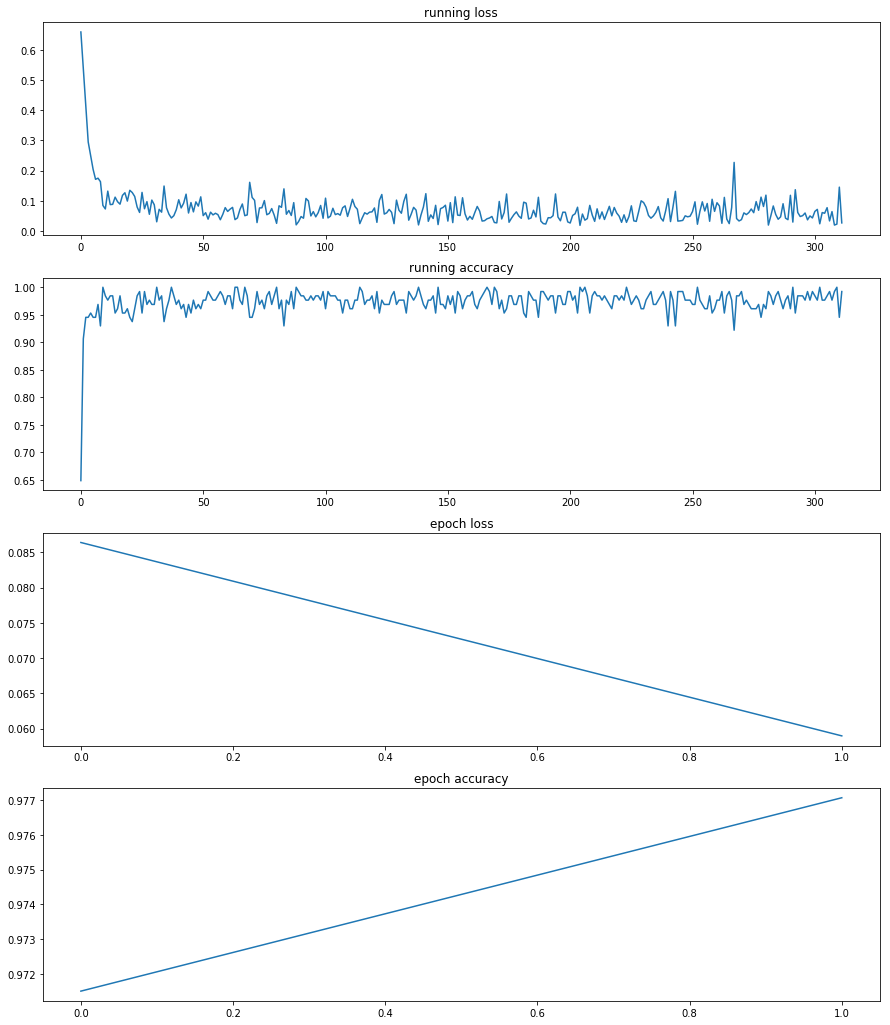

In [15]:
fig,ax=plt.subplots(4,1,figsize=(15,18))

ax[0].plot(running['loss']['train'])
ax[0].set_title('running loss')

ax[1].plot(running['acc']['train'])
ax[1].set_title('running accuracy')

ax[2].plot(epoch_dict['loss']['train'])
ax[2].set_title('epoch loss')

ax[3].plot(epoch_dict['acc']['train'])
ax[3].set_title('epoch accuracy')

保存模型参数

In [ ]:
# save_model='Fusion-0101-0.pkl'
# torch.save(model.state_dict(),save_model)

读取模型参数

In [ ]:
# load_model='./FusionNet-1.pkl'
# model.load_state_dict(torch.load(load_model))

4、用训练过的模型再预测一次每个训练样本的loss，清除loss大于阈值的样本。  
因为训练集97%以上都是正常图片，异常的只占很小一部分，经过两轮epoch训练，模型准确率已达97%，学到的特征偏向于占绝对优势的正常图片，而此时loss仍然大于1.2040（预测正确的概率不超过30%）的样本，十有八九是异常值，非猫狗图片、像素模糊、颜色深暗、背景复杂、角度刁钻，或者一张图同时存在猫和狗。


In [20]:
#-torch.log(torch.Tensor([0.3]))

tensor([ 1.2040])

In [21]:
clean_sets,outliers=[],[]
filter_loader=torch.utils.data.DataLoader(train_sets,batch_size=32,num_workers=4)

model.eval()
for paths,labels in filter_loader:
    res_input=batch_transform(paths,transform['resnet'])
    inc_input=batch_transform(paths,transform['inception'])
    res_input=res_input.to(device)
    inc_input=inc_input.to(device)
    output=model(res_input, inc_input)
    labels=labels.to(device)
    output_t=output.split(1,0)
    labels_t=labels.split(1,0)
    for i in range(len(output_t)):
        loss=criterion(output_t[i],labels_t[i])
        if loss.item()<1.2040:
            clean_sets.append((paths[i],labels[i].item()))
            print('normal loss: %.6f\r'%loss,end='')
        else:
            outliers.append((paths[i],loss.item()))
            print('outlier loss: %.6f'%loss)
        
torch.save(clean_sets,'<1.2040_clean_sets.pkl')

#按loss从大到小排序
sorted_outliers=sorted(outliers,key=lambda x:x[1],reverse=True)
torch.save(sorted_outliers,'<1.2040_sorted_outliers.pkl')

print('%d images are normal, %d images may be outliers.'%(len(clean_sets),len(sorted_outliers)))

outlier loss: 1.482989
outlier loss: 2.257066
outlier loss: 3.411977
outlier loss: 1.983233
outlier loss: 3.100031
outlier loss: 1.209631
outlier loss: 2.334787
outlier loss: 1.406339
outlier loss: 1.214396
outlier loss: 2.502763
outlier loss: 2.494456
outlier loss: 1.293036
outlier loss: 3.959160
outlier loss: 3.328040
outlier loss: 1.830338
outlier loss: 4.050385
outlier loss: 1.569979
outlier loss: 1.205451
outlier loss: 1.641222
outlier loss: 1.374490
outlier loss: 1.677190
outlier loss: 2.668947
outlier loss: 2.079009
outlier loss: 1.989537
outlier loss: 1.699550
outlier loss: 1.322577
outlier loss: 1.593103
outlier loss: 1.345453
outlier loss: 2.624921
outlier loss: 2.142557
outlier loss: 1.339506
outlier loss: 1.440217
outlier loss: 3.049903
outlier loss: 1.714988
outlier loss: 1.740215
outlier loss: 1.759626
outlier loss: 3.842505
outlier loss: 1.913267
outlier loss: 1.451420
outlier loss: 4.079064
outlier loss: 4.661247
outlier loss: 1.880544
outlier loss: 1.804187
outlier los

IndexError: tuple index out of range

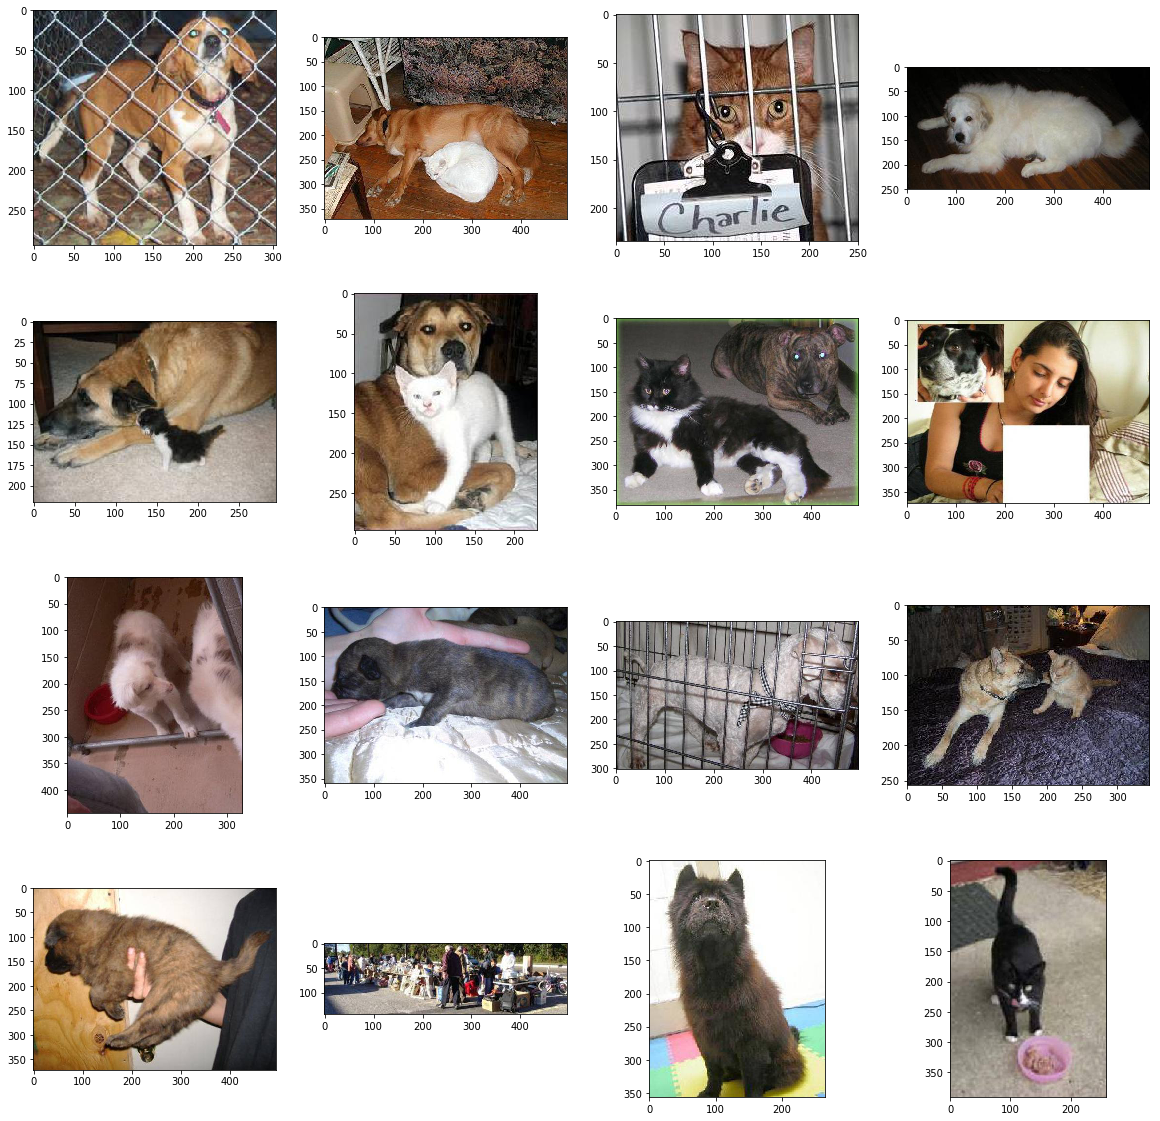

In [23]:
#展示可能异常的图片
fig,ax=plt.subplots(4,4,figsize=(20,20))
for i in range(16):
    ax[i//4,i%4].imshow(Image.open(sorted_outliers[i][0]))

In [10]:
#读取清洗好的数据列表。
# clean_sets=torch.load('<1.2040_clean_sets.pkl')
# len(clean_sets)

19865

5、创建新的train_loader，用清洗过的数据重新训练初始模型。

In [11]:
#此处打开了模型后面几层的参数训练
model=FusionNet(require_grad=True)

#为在GPU上训练做准备
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [12]:
init_lr=0.001
optimizer=torch.optim.SGD([{'params':model.classifier.parameters()},
                           {'params':model.resnet.layer4.parameters(),'lr':init_lr*0.1},
                           {'params':model.inception.Mixed_7c.parameters(),'lr':init_lr*0.1},
                           {'params':model.inception.Mixed_7b.parameters(),'lr':init_lr*0.1},
                           {'params':model.inception.Mixed_7a.parameters(),'lr':init_lr*0.1}],
                          lr=init_lr,momentum=0.91)
# scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.1)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience=2)

In [13]:
epochs=3
every=4 #每every次，暂停训练，进行一次验证
epoch_dict={'loss':{'train':[],'valid':[]},'acc':{'train':[],'valid':[]}}
running={'loss':{'train':[],'valid':[]},'acc':{'train':[],'valid':[]}}
train_loader=torch.utils.data.DataLoader(clean_sets,batch_size=train_batch,shuffle=True,num_workers=4,drop_last=True)
train_size=len(clean_sets)

In [14]:
#用清洗过的训练集训练模型
for epoch in range(1,epochs+1):
    count=0
    running_loss=0
    running_acc=0
    valid_iter=iter(valid_loader)
    
    #train
    model.train()
    for paths,labels in train_loader:
        res_input=batch_transform(paths,transform['resnet'])
        inc_input=batch_transform(paths,transform['inception'])
        res_input=res_input.to(device)
        inc_input=inc_input.to(device)
        optimizer.zero_grad() #计算梯度前清空历史梯度
        output=model(res_input, inc_input)
        labels=labels.to(device)
        loss=criterion(output,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        train_acc=accuracy_score(torch.argmax(output,dim=1),labels)
        running_acc+=train_acc

        count+=1
        print('epoch:%d, training:%d/%d, loss:%.6f, accuracy:%.4f\r'%(epoch,train_batch*count,train_size,loss,train_acc),end='')
        if count%every==0:
            average_loss=running_loss/every #every个batch的平均loss
            average_acc=running_acc/every #every个batch的平均accuracy
            print('epoch:%d, training:%d/%d, average_loss:%.6f, accuracy:%.4f\r'
                  %(epoch,train_batch*count,train_size,average_loss,average_acc))
            running['loss']['train'].append(average_loss)
            running['acc']['train'].append(average_acc)
            running_loss=0
            running_acc=0
            
            #validate
            model.eval()
            paths,labels=next(valid_iter)
            res_input=batch_transform(paths,transform['resnet'])
            inc_input=batch_transform(paths,transform['inception'])
            res_input=res_input.to(device)
            inc_input=inc_input.to(device)
            output=model(res_input, inc_input)
            labels=labels.to(device)
            loss=criterion(output,labels)
            valid_acc=accuracy_score(torch.argmax(output,dim=1),labels)
            print('epoch:%d, validation:%d/%d, loss:%.6f, accuracy:%.4f'%(epoch,valid_batch*count/every,valid_size,loss,valid_acc))
            running['loss']['valid'].append(loss.item())
            running['acc']['valid'].append(valid_acc)
            model.train()
    e_count=int(count/every)
    e_train_loss=sum(running['loss']['train'][-e_count:])/e_count
    e_train_acc=sum(running['acc']['train'][-e_count:])/e_count
    e_valid_loss=sum(running['loss']['valid'][-e_count:])/e_count
    e_valid_acc=sum(running['acc']['valid'][-e_count:])/e_count
    print('\nepoch %d, average training loss:%.6f ; training accuracy:%.4f'%(epoch,e_train_loss,e_train_acc))
    print('\nepoch %d, average validation loss:%.6f ; validation accuracy:%.4f'%(epoch,e_valid_loss,e_valid_acc))
    epoch_dict['loss']['train'].append(e_train_loss)
    epoch_dict['loss']['valid'].append(e_valid_loss)
    epoch_dict['acc']['train'].append(e_train_acc)
    epoch_dict['acc']['valid'].append(e_valid_acc)
    torch.save(model.state_dict(),'./FusionNet-%s.pkl'%epoch)
    torch.save(running,'./running-%s.pkl'%epoch)
    torch.save(epoch_dict,'./epoch_dict-%s.pkl'%epoch)
    scheduler.step(epoch_dict['loss']['valid'][-1])

epoch:1, training:128/19865, average_loss:0.691701, accuracy:0.5469
epoch:1, validation:32/4995, loss:0.694622, accuracy:0.5312
epoch:1, training:256/19865, average_loss:0.694850, accuracy:0.5000
epoch:1, validation:64/4995, loss:0.696635, accuracy:0.4688
epoch:1, training:384/19865, average_loss:0.691613, accuracy:0.5547
epoch:1, validation:96/4995, loss:0.692722, accuracy:0.5625
epoch:1, training:512/19865, average_loss:0.690854, accuracy:0.5156
epoch:1, validation:128/4995, loss:0.692862, accuracy:0.5000
epoch:1, training:640/19865, average_loss:0.689890, accuracy:0.5391
epoch:1, validation:160/4995, loss:0.689568, accuracy:0.4688
epoch:1, training:768/19865, average_loss:0.686890, accuracy:0.6016
epoch:1, validation:192/4995, loss:0.689673, accuracy:0.5312
epoch:1, training:896/19865, average_loss:0.686345, accuracy:0.6172
epoch:1, validation:224/4995, loss:0.683125, accuracy:0.7500
epoch:1, training:1024/19865, average_loss:0.684549, accuracy:0.7031
epoch:1, validation:256/4995, l

epoch:1, training:8192/19865, average_loss:0.138116, accuracy:0.9844
epoch:1, validation:2048/4995, loss:0.082545, accuracy:1.0000
epoch:1, training:8320/19865, average_loss:0.149416, accuracy:0.9844
epoch:1, validation:2080/4995, loss:0.106782, accuracy:1.0000
epoch:1, training:8448/19865, average_loss:0.134239, accuracy:0.9609
epoch:1, validation:2112/4995, loss:0.105469, accuracy:0.9688
epoch:1, training:8576/19865, average_loss:0.117970, accuracy:0.9766
epoch:1, validation:2144/4995, loss:0.069484, accuracy:1.0000
epoch:1, training:8704/19865, average_loss:0.104445, accuracy:0.9844
epoch:1, validation:2176/4995, loss:0.087106, accuracy:0.9688
epoch:1, training:8832/19865, average_loss:0.124450, accuracy:0.9766
epoch:1, validation:2208/4995, loss:0.098337, accuracy:0.9688
epoch:1, training:8960/19865, average_loss:0.136489, accuracy:0.9609
epoch:1, validation:2240/4995, loss:0.113666, accuracy:0.9688
epoch:1, training:9088/19865, average_loss:0.084461, accuracy:0.9766
epoch:1, valid

epoch:2, training:4224/19865, average_loss:0.055972, accuracy:0.9766
epoch:2, validation:1056/4995, loss:0.035941, accuracy:0.9688
epoch:2, training:4352/19865, average_loss:0.035671, accuracy:0.9844
epoch:2, validation:1088/4995, loss:0.040743, accuracy:0.9688
epoch:2, training:4480/19865, average_loss:0.087610, accuracy:0.9453
epoch:2, validation:1120/4995, loss:0.075334, accuracy:0.9688
epoch:2, training:4608/19865, average_loss:0.043038, accuracy:0.9688
epoch:2, validation:1152/4995, loss:0.098182, accuracy:0.9688
epoch:2, training:4736/19865, average_loss:0.029433, accuracy:0.9922
epoch:2, validation:1184/4995, loss:0.022210, accuracy:1.0000
epoch:2, training:4864/19865, average_loss:0.024065, accuracy:0.9922
epoch:2, validation:1216/4995, loss:0.010316, accuracy:1.0000
epoch:2, training:4992/19865, average_loss:0.023681, accuracy:0.9922
epoch:2, validation:1248/4995, loss:0.047625, accuracy:0.9688
epoch:2, training:5120/19865, average_loss:0.031007, accuracy:0.9844
epoch:2, valid

epoch:3, training:128/19865, average_loss:0.021998, accuracy:0.9922
epoch:3, validation:32/4995, loss:0.001508, accuracy:1.0000
epoch:3, training:256/19865, average_loss:0.029220, accuracy:0.9922
epoch:3, validation:64/4995, loss:0.018873, accuracy:1.0000
epoch:3, training:384/19865, average_loss:0.037650, accuracy:0.9922
epoch:3, validation:96/4995, loss:0.013405, accuracy:1.0000
epoch:3, training:512/19865, average_loss:0.018822, accuracy:0.9922
epoch:3, validation:128/4995, loss:0.043508, accuracy:0.9688
epoch:3, training:640/19865, average_loss:0.043414, accuracy:0.9844
epoch:3, validation:160/4995, loss:0.063455, accuracy:0.9688
epoch:3, training:768/19865, average_loss:0.026969, accuracy:0.9844
epoch:3, validation:192/4995, loss:0.070142, accuracy:0.9688
epoch:3, training:896/19865, average_loss:0.024964, accuracy:0.9844
epoch:3, validation:224/4995, loss:0.005206, accuracy:1.0000
epoch:3, training:1024/19865, average_loss:0.029512, accuracy:0.9922
epoch:3, validation:256/4995, l

epoch:3, training:8192/19865, average_loss:0.047328, accuracy:0.9844
epoch:3, validation:2048/4995, loss:0.007661, accuracy:1.0000
epoch:3, training:8320/19865, average_loss:0.023060, accuracy:0.9922
epoch:3, validation:2080/4995, loss:0.014546, accuracy:1.0000
epoch:3, training:8448/19865, average_loss:0.071747, accuracy:0.9844
epoch:3, validation:2112/4995, loss:0.002503, accuracy:1.0000
epoch:3, training:8576/19865, average_loss:0.065831, accuracy:0.9922
epoch:3, validation:2144/4995, loss:0.108275, accuracy:0.9375
epoch:3, training:8704/19865, average_loss:0.058758, accuracy:0.9766
epoch:3, validation:2176/4995, loss:0.044427, accuracy:0.9688
epoch:3, training:8832/19865, average_loss:0.025544, accuracy:0.9922
epoch:3, validation:2208/4995, loss:0.074384, accuracy:0.9688
epoch:3, training:8960/19865, average_loss:0.025163, accuracy:0.9922
epoch:3, validation:2240/4995, loss:0.001227, accuracy:1.0000
epoch:3, training:9088/19865, average_loss:0.009751, accuracy:1.0000
epoch:3, valid

Text(0.5,1,'epoch accuracy')

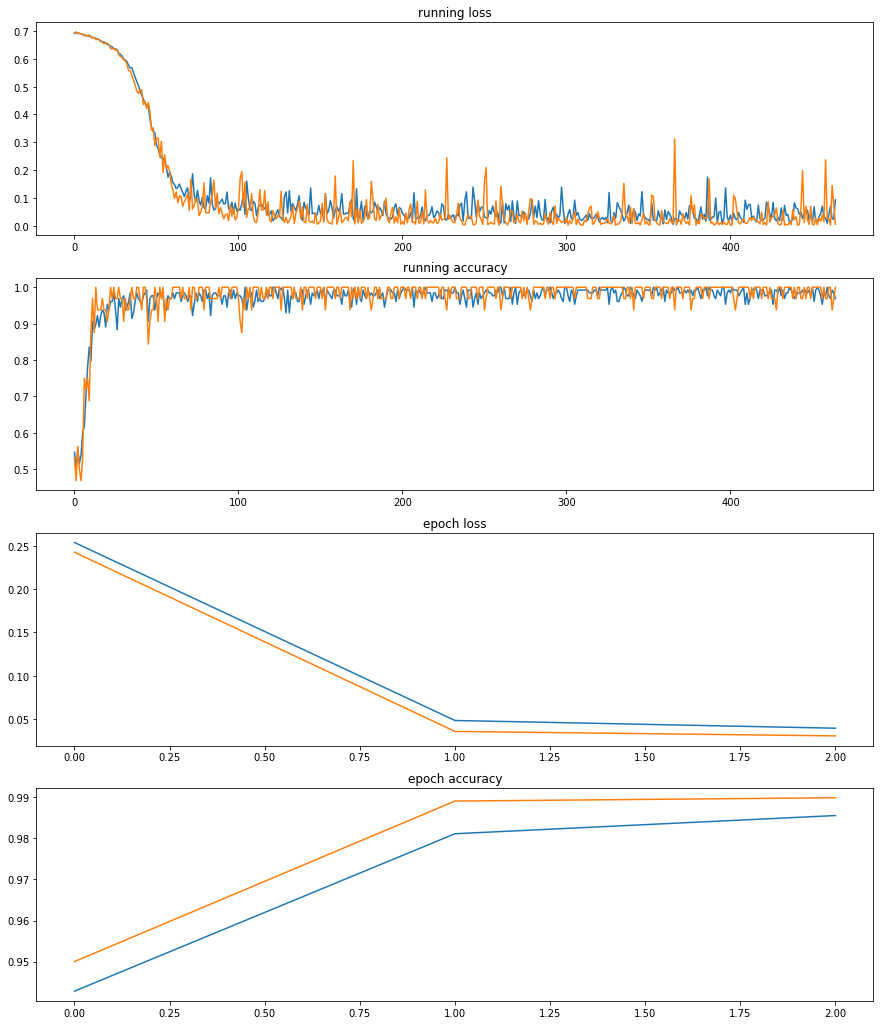

In [15]:
fig,ax=plt.subplots(4,1,figsize=(15,18))

ax[0].plot(running['loss']['train'])
ax[0].plot(running['loss']['valid'])
ax[0].set_title('running loss')

ax[1].plot(running['acc']['train'])
ax[1].plot(running['acc']['valid'])
ax[1].set_title('running accuracy')

ax[2].plot(epoch_dict['loss']['train'])
ax[2].plot(epoch_dict['loss']['valid'])
ax[2].set_title('epoch loss')

ax[3].plot(epoch_dict['acc']['train'])
ax[3].plot(epoch_dict['acc']['valid'])
ax[3].set_title('epoch accuracy')

In [19]:
# load_model='./FusionNet-2.pkl'
# model.load_state_dict(torch.load(load_model))

三、预测测试集  

1、准备测试数据

In [20]:
import pandas as pd

test_dir=os.path.join(data_dir,'test')
test_images=os.listdir(test_dir)
test_sets=[(os.path.join(test_dir,fn),int(fn[:-4])) for fn in test_images] #test_sets数据类型为(image_path,ID)
test_size=len(test_sets)
print('test_sets: %d'%(test_size))

test_sets: 12500


2、预测图片是狗的概率

In [21]:
#创建一个空的带header的DataFrame
df=pd.DataFrame(columns=['id','label'])

#test
count=0
model.eval()
test_loader=torch.utils.data.DataLoader(test_sets,batch_size=50,num_workers=4)
for paths,ID in test_loader:
    res_input=batch_transform(paths,transform['resnet'])
    inc_input=batch_transform(paths,transform['inception'])
    res_input=res_input.to(device)
    inc_input=inc_input.to(device)
    output=model(res_input, inc_input)
    dog_probs=torch.nn.functional.softmax(output,dim=1).data[:,1] #图片是狗的概率
    df=df.append(pd.DataFrame({'id':ID,'label':dog_probs}),ignore_index=True)
    count+=1
    print('processing: %d/%d\r'%(count*50,test_size),end='')

3、依id排序，将DataFrame写入csv文件。

In [22]:
csv_file='submission.csv'
df.sort_values(by='id',inplace=True)
df.to_csv(csv_file,index=False)
print(df)

          id     label
8485       1  0.999153
8403       2  0.999862
8316       3  0.999437
10466      4  0.999736
1464       5  0.000490
7874       6  0.000254
11042      7  0.000026
3874       8  0.000426
8647       9  0.000763
6454      10  0.002492
1070      11  0.003944
906       12  0.998541
11819     13  0.000360
10514     14  0.001533
9988      15  0.000508
1546      16  0.000085
2307      17  0.991919
11742     18  0.999528
12051     19  0.000173
3798      20  0.000451
10554     21  0.999591
5293      22  0.000579
8056      23  0.999831
9138      24  0.998332
11469     25  0.000363
8466      26  0.998034
4351      27  0.998393
4670      28  0.000092
10061     29  0.518122
3125      30  0.998335
...      ...       ...
9374   12471  0.999291
4655   12472  0.998651
10549  12473  0.000108
7234   12474  0.000186
607    12475  0.000265
1892   12476  0.996553
1311   12477  0.999761
2322   12478  0.642651
10705  12479  0.001231
3020   12480  0.000625
10582  12481  0.020960
6289   1248